In [37]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [38]:
import sklearn

In [39]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [212]:
pos_final_test = pd.read_csv('./data/pos_KNN_final_test.csv.gz', compression='gzip')

model_cols = pos_final_test.columns.str.contains('abn') | pos_final_test.columns.isin(['gender', 'age','ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN'])
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

# pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') |pos_final_test.columns.str.contains('above') |

In [5]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

In [213]:
hadm_features

,"('abn_percent', 'Anion Gap - Blood - Chemistry')","('abn_percent', 'Bicarbonate - Blood - Chemistry')","('abn_percent', 'Calcium, Total - Blood - Chemistry')","('abn_percent', 'Chloride - Blood - Chemistry')","('abn_percent', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('abn_percent', 'Creatinine - Blood - Chemistry')","('abn_percent', 'Glucose - Blood - Chemistry')","('abn_percent', 'Magnesium - Blood - Chemistry')","('abn_percent', 'Phosphate - Blood - Chemistry')","('abn_percent', 'Potassium - Blood - Chemistry')","('abn_percent', 'Sodium - Blood - Chemistry')","('abn_percent', 'Troponin T - Blood - Chemistry')","('abn_percent', 'Urea Nitrogen - Blood - Chemistry')","('abn_percent', 'Hematocrit - Blood - Hematology')","('abn_percent', 'Hemoglobin - Blood - Hematology')","('abn_percent', 'MCH - Blood - Hematology')","('abn_percent', 'MCHC - Blood - Hematology')","('abn_percent', 'MCV - Blood - Hematology')","('abn_percent', 'Platelet Count - Blood - Hematology')","('abn_percent', 'PT - Blood - Hematology')","('abn_percent', 'RDW - Blood - Hematology')","('abn_percent', 'Red Blood Cells - Blood - Hematology')","('abn_percent', 'White Blood Cells - Blood - Hematology')","('abn_percent', 'Bilirubin - Urine - Hematology')",gender,age,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC/LATINO,ethnicity_OTHER,ethnicity_UNKNOWN
0,0.974676,2.987109,0.952974,-0.238866,5.507861,1.791873,1.069785,-0.398598,-0.904234,-0.395179,1.508224,2.479239,1.816300,0.352620,0.274429,-0.637841,-0.657253,-0.466447,0.188876,0.148065,-0.503833,0.673301,1.788046,-0.161861,0.0,1.163393,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.349741,-0.558297,-0.053019,1.333729,-0.001474,0.420978,0.159134,-0.398598,0.101027,-0.395179,-0.416140,0.122384,-0.805906,0.790742,0.763336,-0.637841,2.178161,1.371988,-0.606473,1.428584,-0.503833,0.673301,-0.327836,0.091179,0.0,-0.424744,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.349741,0.317112,-0.849779,3.255789,-0.837443,1.644991,1.069785,1.765603,0.238092,0.296540,1.700661,-1.446508,1.488524,-1.618931,-1.681199,1.592163,-0.657253,2.597611,-0.241938,-1.388557,-0.503833,0.673301,0.135013,-0.161861,1.0,1.368313,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.349741,-0.558297,-0.849779,-0.588331,0.012118,-0.558232,-1.662168,-0.398598,-0.904234,-0.395179,-0.416140,-0.312805,-0.805906,0.790742,0.763336,1.910735,-0.657253,2.597611,-0.606473,0.036661,-0.503833,0.673301,-0.856807,-0.094384,0.0,-1.295657,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.349741,-0.558297,-0.849779,-0.588331,0.146193,-0.558232,1.069785,-0.398598,-0.904234,-0.395179,-0.416140,0.018612,-0.805906,-1.618931,0.763336,-0.637841,-0.657253,-0.466447,-0.606473,-1.388557,-0.503833,0.673301,1.788046,0.377958,0.0,-1.090736,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,-0.349741,-0.558297,0.188747,-0.588331,-0.837443,-0.558232,-1.662168,0.077760,0.055682,-0.395179,-0.416140,-1.446508,-0.805906,-1.618931,0.763336,-0.637841,-0.657253,-0.466447,-0.606473,-0.018877,-0.503833,0.673301,-0.856807,0.138413,1.0,-0.117362,0.0,0.0,0.0,0.0,1.0,0.0
8728,-0.349741,-0.558297,-0.849779,-0.588331,-0.017557,2.379399,-1.662168,-0.398598,-0.904234,-0.395179,-0.416140,-0.068275,1.816300,0.790742,0.763336,1.910735,-0.657253,2.597611,-0.606473,0.021302,-0.503833,0.673301,-0.856807,0.138413,0.0,1.060932,0.0,0.0,0.0,0.0,0.0,0.0
8729,-0.349741,1.849077,0.752668,2.828665,0.329085,-0.558232,1.069785,0.034242,-0.904234,-0.395179,4.875862,-0.195616,-0.805906,0.790742,0.763336,-0.637841,-0.657253,2.597611,-0.606473,1.428584,-0.503833,0.673301,0.024811,-0.161861,0.0,1.573234,0.0,1.0,0.0,0.0,0.0,0.0
8730,2.330627,-0.464503,0.008675,1.242202,-0.017205,-0.558232,0.809599,-0.081886,0.760297,-0.065789,2.229861,0.324651,1.316832,0.719869,0.763336,-0.637841,0.009903,-0.466447,1.623621,1.428584,2.355201,0.673301,-0.001119,-0.161861,0.0,0.446170,0.0,0.0,0.0,0.0,0.0,0.0


## Train test split

In [214]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [215]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [216]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7533
Target=1:  1199


In [217]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))

In [218]:
def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='roc_auc',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('roc_auc')

## Logistic Regression

### Basic

In [219]:
%%time

params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log.fit(X_train, y_train)

CPU times: user 4.11 s, sys: 420 ms, total: 4.53 s
Wall time: 4.1 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.06210526315789474}
Best CV score:  0.8411
Accuracy Score: 77.56%
_______________________________________________
Classification Report:	Precision Score: 34.86%
			Recall Score: 72.92%
			F1 score: 47.17%
			ROC_AUC score: 75.61%
_______________________________________________
Confusion Matrix: 
 [[1180  327]
 [  65  175]]



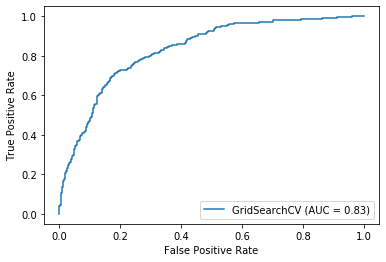

age                                                                     0.883461
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')                    0.401278
('abn_percent', 'RDW - Blood - Hematology')                             0.357141
('abn_percent', 'Hematocrit - Blood - Hematology')                      0.334735
('abn_percent', 'Hemoglobin - Blood - Hematology')                      0.333328
('abn_percent', 'PT - Blood - Hematology')                              0.231880
('abn_percent', 'Calcium, Total - Blood - Chemistry')                   0.211394
('abn_percent', 'Glucose - Blood - Chemistry')                          0.200629
('abn_percent', 'Creatinine - Blood - Chemistry')                       0.199113
('abn_percent', 'Troponin T - Blood - Chemistry')                       0.185538
('abn_percent', 'MCHC - Blood - Hematology')                            0.135287
gender                                                                  0.072716
('abn_percent', 'Magnesium -

In [220]:
results(grid_log)

In [222]:
# from sklearn.feature_selection import RFECV
# selector = RFECV(grid_log, step=1, cv=5)
# selector = selector.fit(X_train, y_train)
# selector.support_

### Over Sampling using SMOTE

In [223]:
%%time
params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_over = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_over.fit(X_res_over, y_res_over)

CPU times: user 6.19 s, sys: 652 ms, total: 6.84 s
Wall time: 6.65 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.2705263157894737}
Best CV score:  0.8517
Accuracy Score: 78.08%
_______________________________________________
Classification Report:	Precision Score: 35.67%
			Recall Score: 74.17%
			F1 score: 48.17%
			ROC_AUC score: 76.43%
_______________________________________________
Confusion Matrix: 
 [[1186  321]
 [  62  178]]



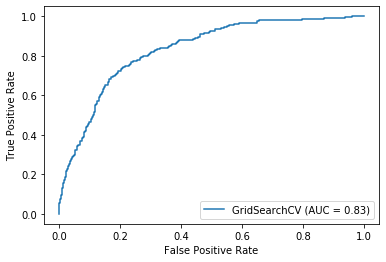

age                                                          1.010455
ethnicity_OTHER                                              0.486865
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')         0.483370
('abn_percent', 'Hemoglobin - Blood - Hematology')           0.439073
('abn_percent', 'Hematocrit - Blood - Hematology')           0.404144
('abn_percent', 'RDW - Blood - Hematology')                  0.363754
('abn_percent', 'PT - Blood - Hematology')                   0.309404
('abn_percent', 'Glucose - Blood - Chemistry')               0.263395
('abn_percent', 'Calcium, Total - Blood - Chemistry')        0.261104
ethnicity_AMERICAN INDIAN/ALASKA NATIVE                      0.245584
ethnicity_UNKNOWN                                            0.226525
('abn_percent', 'Troponin T - Blood - Chemistry')            0.192495
gender                                                       0.159918
('abn_percent', 'Magnesium - Blood - Chemistry')             0.136229
('abn_percent', 'Cre

In [224]:
results(grid_log_over)

### Under Sampling using Near Miss

In [225]:
%%time
params ={'C':np.linspace(1e-2,100,100)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_under = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_under.fit(X_res_under, y_res_under)

CPU times: user 8.83 s, sys: 912 ms, total: 9.74 s
Wall time: 10.2 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01,
       1.213e+01, 1.314e+01, 1.415e+01, 1.516e+01, 1.617e+01, 1.718e+01,
       1.819e+01, 1.920e+01, 2.021e+01...
       6.667e+01, 6.768e+01, 6.869e+01, 6.970e+01, 7.071e+01, 7.172e+01,
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 1.02}
Best CV score:  0.9195
Accuracy Score: 64.22%
_______________________________________________
Classification Report:	Precision Score: 24.70%
			Recall Score: 78.33%
			F1 score: 37.56%
			ROC_AUC score: 70.16%
_______________________________________________
Confusion Matrix: 
 [[934 573]
 [ 52 188]]



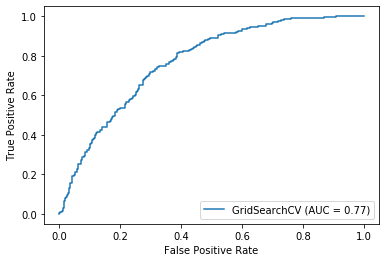

age                                                          1.152913
ethnicity_UNKNOWN                                            1.046590
ethnicity_BLACK/AFRICAN AMERICAN                             0.874634
('abn_percent', 'Hematocrit - Blood - Hematology')           0.865100
('abn_percent', 'RDW - Blood - Hematology')                  0.791986
('abn_percent', 'Potassium - Blood - Chemistry')             0.618700
ethnicity_OTHER                                              0.596561
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')         0.541995
('abn_percent', 'Bicarbonate - Blood - Chemistry')           0.537057
('abn_percent', 'MCHC - Blood - Hematology')                 0.460364
('abn_percent', 'MCH - Blood - Hematology')                  0.445406
('abn_percent', 'Hemoglobin - Blood - Hematology')           0.441334
('abn_percent', 'Chloride - Blood - Chemistry')              0.416333
('abn_percent', 'Platelet Count - Blood - Hematology')       0.379424
('abn_percent', 'Bil

In [226]:
results(grid_log_under)

## Random Forest

### RF_Over Sampling using SMOTE

In [ ]:
plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,35,3), X_res_over, y_res_over)

In [229]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(120,121,1),
            'max_depth': range(12,22,3)
            }

grid_rf_over = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_over.fit(X_res_over, y_res_over)

CPU times: user 32.7 s, sys: 1.04 s, total: 33.8 s
Wall time: 47.5 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(12, 22, 3),
                         'n_estimators': range(120, 121)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 21, 'n_estimators': 120}
Best CV score:  0.9808
Accuracy Score: 85.58%
_______________________________________________
Classification Report:	Precision Score: 47.30%
			Recall Score: 43.75%
			F1 score: 45.45%
			ROC_AUC score: 67.99%
_______________________________________________
Confusion Matrix: 
 [[1390  117]
 [ 135  105]]



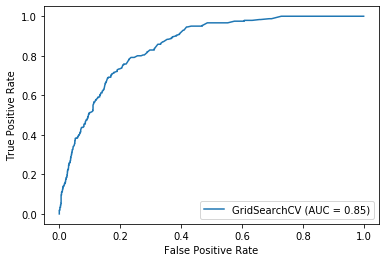

age                                                                     0.139458
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')                    0.117819
('abn_percent', 'Creatinine - Blood - Chemistry')                       0.058516
('abn_percent', 'Troponin T - Blood - Chemistry')                       0.058253
('abn_percent', 'RDW - Blood - Hematology')                             0.051533
('abn_percent', 'PT - Blood - Hematology')                              0.050781
('abn_percent', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')    0.043476
('abn_percent', 'Bicarbonate - Blood - Chemistry')                      0.039265
gender                                                                  0.038466
('abn_percent', 'Glucose - Blood - Chemistry')                          0.036771
('abn_percent', 'Calcium, Total - Blood - Chemistry')                   0.033931
('abn_percent', 'White Blood Cells - Blood - Hematology')               0.031455
('abn_percent', 'Phosphate -

In [230]:
results(grid_rf_over)

### RF_Under Sampling using Near Miss

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 35, 3) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


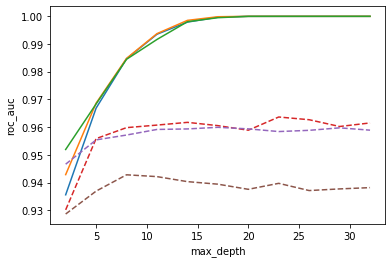

In [231]:
plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,35,3), X_res_under, y_res_under)

In [232]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(420,421,1),
            'max_depth': range(10,20,2)
            }

grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_under.fit(X_res_under, y_res_under)

CPU times: user 24.2 s, sys: 646 ms, total: 24.8 s
Wall time: 31.1 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(10, 20, 2),
                         'n_estimators': range(420, 421)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 420}
Best CV score:  0.9558
Accuracy Score: 48.43%
_______________________________________________
Classification Report:	Precision Score: 19.65%
			Recall Score: 89.17%
			F1 score: 32.20%
			ROC_AUC score: 65.55%
_______________________________________________
Confusion Matrix: 
 [[632 875]
 [ 26 214]]



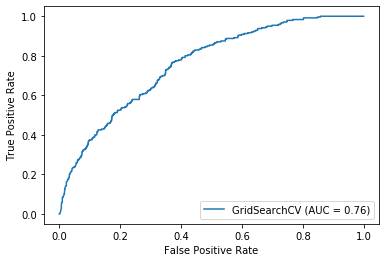

('abn_percent', 'Urea Nitrogen - Blood - Chemistry')                    0.128713
('abn_percent', 'RDW - Blood - Hematology')                             0.106697
('abn_percent', 'Troponin T - Blood - Chemistry')                       0.083356
('abn_percent', 'Creatinine - Blood - Chemistry')                       0.080454
('abn_percent', 'Chloride - Blood - Chemistry')                         0.064051
('abn_percent', 'Bicarbonate - Blood - Chemistry')                      0.059491
('abn_percent', 'MCH - Blood - Hematology')                             0.049865
('abn_percent', 'PT - Blood - Hematology')                              0.045253
('abn_percent', 'Phosphate - Blood - Chemistry')                        0.044297
('abn_percent', 'MCHC - Blood - Hematology')                            0.043785
('abn_percent', 'Platelet Count - Blood - Hematology')                  0.037521
('abn_percent', 'MCV - Blood - Hematology')                             0.036746
age                         

In [233]:
results(grid_rf_under)

## Gradient Boost

### GB_Over Sampling using SMOTE¶

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(3, 20, 5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


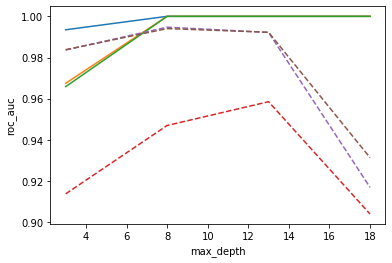

In [236]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(3,20,5), X_res_over, y_res_over)

In [263]:
%%time
param_grid={'n_estimators':range(250,251,1),
            'max_depth':range(8,13,1),
            }

grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_over.fit(X_res_over, y_res_over)

CPU times: user 9min 48s, sys: 10.8 s, total: 9min 59s
Wall time: 11min 34s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(8, 13),
                         'n_estimators': range(250, 251)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'max_depth': 12, 'n_estimators': 250}
Best CV score:  0.9851
Accuracy Score: 86.03%
_______________________________________________
Classification Report:	Precision Score: 48.90%
			Recall Score: 37.08%
			F1 score: 42.18%
			ROC_AUC score: 65.46%
_______________________________________________
Confusion Matrix: 
 [[1414   93]
 [ 151   89]]



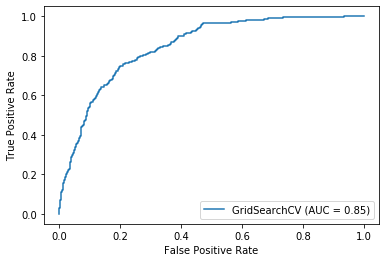

age                                                                     0.230701
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')                    0.182252
('abn_percent', 'RDW - Blood - Hematology')                             0.056384
('abn_percent', 'PT - Blood - Hematology')                              0.043955
('abn_percent', 'Troponin T - Blood - Chemistry')                       0.040154
('abn_percent', 'Calcium, Total - Blood - Chemistry')                   0.038187
('abn_percent', 'Creatinine - Blood - Chemistry')                       0.030950
('abn_percent', 'White Blood Cells - Blood - Hematology')               0.030044
('abn_percent', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')    0.029290
gender                                                                  0.026834
('abn_percent', 'Bicarbonate - Blood - Chemistry')                      0.026045
('abn_percent', 'Glucose - Blood - Chemistry')                          0.026035
('abn_percent', 'Phosphate -

In [264]:
results(grid_gb_over)

In [237]:
# %%time
# param_grid={'n_estimators':range(150,151,1),
#             'max_depth':range(13,14,1),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(8,17,2),
#             }
# # 'max_depth': 9, 'n_estimators': 80
# grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_over.fit(X_res_over, y_res_over)

In [238]:
# results(grid_gb_over)

### GB_Under Sampling using Near Miss

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 7) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


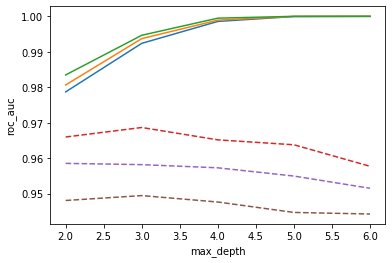

In [240]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(2,7,1),X_res_under, y_res_under)

In [243]:
%%time
param_grid={'n_estimators':range(250,251,1),
            'max_depth':range(2,9,2),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_under.fit(X_res_under, y_res_under)

CPU times: user 32.3 s, sys: 633 ms, total: 33 s
Wall time: 47.2 s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(2, 9, 2),
                         'n_estimators': range(250, 251)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'max_depth': 2, 'n_estimators': 250}
Best CV score:  0.9595
Accuracy Score: 51.23%
_______________________________________________
Classification Report:	Precision Score: 20.41%
			Recall Score: 87.92%
			F1 score: 33.12%
			ROC_AUC score: 66.65%
_______________________________________________
Confusion Matrix: 
 [[684 823]
 [ 29 211]]



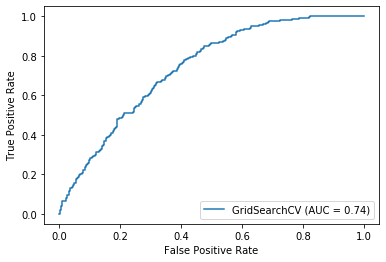

('abn_percent', 'Urea Nitrogen - Blood - Chemistry')                    0.289313
('abn_percent', 'RDW - Blood - Hematology')                             0.146702
('abn_percent', 'Troponin T - Blood - Chemistry')                       0.086486
('abn_percent', 'MCH - Blood - Hematology')                             0.067108
('abn_percent', 'Chloride - Blood - Chemistry')                         0.053618
('abn_percent', 'PT - Blood - Hematology')                              0.051312
('abn_percent', 'Bicarbonate - Blood - Chemistry')                      0.047607
('abn_percent', 'MCHC - Blood - Hematology')                            0.040686
('abn_percent', 'Phosphate - Blood - Chemistry')                        0.033164
('abn_percent', 'Platelet Count - Blood - Hematology')                  0.030457
('abn_percent', 'Creatinine - Blood - Chemistry')                       0.026408
('abn_percent', 'Potassium - Blood - Chemistry')                        0.020077
age                         

In [244]:
results(grid_gb_under)

In [241]:
# %%time
# param_grid={'n_estimators':range(80,81,1),
#             'max_depth':range(2,9,2),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(7,12,2),
#             }

# grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_under.fit(X_res_under, y_res_under)

In [242]:
# results(grid_gb_under)

## Gather Metrics

In [265]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for model, model_name in model_list:
        pred = model.best_estimator_.predict(X_test)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        metrics = metrics.append({'Model':model_name,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
#         print(model_name,' processed')
    return metrics

In [266]:
model_list=[(grid_log,'logistic_basic'),(grid_log_under,'logistic_under'),(grid_log_over,'logistic_over'), 
            (grid_gb_under,'gradient_boost_under'),(grid_gb_over,'gradient_boost_over'),
            (grid_rf_under,'random_forest_under'),(grid_rf_over,'random_forest_over')
           ]
gather_metrics(model_list)

,Model,F1,ROC_AUC,Recall,Accuracy,Precision
0,logistic_basic,0.471698,0.756090,0.729167,0.775615,0.348606
1,logistic_under,0.375624,0.701554,0.783333,0.642244,0.247043
2,logistic_over,0.481732,0.764330,0.741667,0.780767,0.356713
3,gradient_boost_under,0.331240,0.666524,0.879167,0.512307,0.204062
4,gradient_boost_over,0.421801,0.654561,0.370833,0.860332,0.489011
5,random_forest_under,0.322047,0.655521,0.891667,0.484259,0.196511
6,random_forest_over,0.454545,0.679931,0.437500,0.855753,0.472973


## Gather Best Features

In [267]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

In [268]:
gather_best_features(model_list)

,features,logistic_basic,features,logistic_under,features,logistic_over,features,gradient_boost_under,features,gradient_boost_over,features,random_forest_under,features,random_forest_over
0,age,0.883461,age,0.883461,age,0.883461,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.289313,age,0.230701,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.128713,age,0.139458
1,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.401278,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.401278,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.401278,"('abn_percent', 'RDW - Blood - Hematology')",0.146702,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.182252,"('abn_percent', 'RDW - Blood - Hematology')",0.106697,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.117819
2,"('abn_percent', 'RDW - Blood - Hematology')",0.357141,"('abn_percent', 'RDW - Blood - Hematology')",0.357141,"('abn_percent', 'RDW - Blood - Hematology')",0.357141,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.086486,"('abn_percent', 'RDW - Blood - Hematology')",0.056384,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.083356,"('abn_percent', 'Creatinine - Blood - Chemistry')",0.058516
3,"('abn_percent', 'Hematocrit - Blood - Hematolo...",0.334735,"('abn_percent', 'Hematocrit - Blood - Hematolo...",0.334735,"('abn_percent', 'Hematocrit - Blood - Hematolo...",0.334735,"('abn_percent', 'MCH - Blood - Hematology')",0.067108,"('abn_percent', 'PT - Blood - Hematology')",0.043955,"('abn_percent', 'Creatinine - Blood - Chemistry')",0.080454,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.058253
4,"('abn_percent', 'Hemoglobin - Blood - Hematolo...",0.333328,"('abn_percent', 'Hemoglobin - Blood - Hematolo...",0.333328,"('abn_percent', 'Hemoglobin - Blood - Hematolo...",0.333328,"('abn_percent', 'Chloride - Blood - Chemistry')",0.053618,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.040154,"('abn_percent', 'Chloride - Blood - Chemistry')",0.064051,"('abn_percent', 'RDW - Blood - Hematology')",0.051533
5,"('abn_percent', 'PT - Blood - Hematology')",0.231880,"('abn_percent', 'PT - Blood - Hematology')",0.231880,"('abn_percent', 'PT - Blood - Hematology')",0.231880,"('abn_percent', 'PT - Blood - Hematology')",0.051312,"('abn_percent', 'Calcium, Total - Blood - Chem...",0.038187,"('abn_percent', 'Bicarbonate - Blood - Chemist...",0.059491,"('abn_percent', 'PT - Blood - Hematology')",0.050781
6,"('abn_percent', 'Calcium, Total - Blood - Chem...",0.211394,"('abn_percent', 'Calcium, Total - Blood - Chem...",0.211394,"('abn_percent', 'Calcium, Total - Blood - Chem...",0.211394,"('abn_percent', 'Bicarbonate - Blood - Chemist...",0.047607,"('abn_percent', 'Creatinine - Blood - Chemistry')",0.030950,"('abn_percent', 'MCH - Blood - Hematology')",0.049865,"('abn_percent', 'Creatine Kinase, MB Isoenzyme...",0.043476
7,"('abn_percent', 'Glucose - Blood - Chemistry')",0.200629,"('abn_percent', 'Glucose - Blood - Chemistry')",0.200629,"('abn_percent', 'Glucose - Blood - Chemistry')",0.200629,"('abn_percent', 'MCHC - Blood - Hematology')",0.040686,"('abn_percent', 'White Blood Cells - Blood - H...",0.030044,"('abn_percent', 'PT - Blood - Hematology')",0.045253,"('abn_percent', 'Bicarbonate - Blood - Chemist...",0.039265
8,"('abn_percent', 'Creatinine - Blood - Chemistry')",0.199113,"('abn_percent', 'Creatinine - Blood - Chemistry')",0.199113,"('abn_percent', 'Creatinine - Blood - Chemistry')",0.199113,"('abn_percent', 'Phosphate - Blood - Chemistry')",0.033164,"('abn_percent', 'Creatine Kinase, MB Isoenzyme...",0.029290,"('abn_percent', 'Phosphate - Blood - Chemistry')",0.044297,gender,0.038466
9,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.185538,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.185538,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.185538,"('abn_percent', 'Platelet Count - Blood - Hema...",0.030457,gender,0.026834,"('abn_percent', 'MCHC - Blood - Hematology')",0.043785,"('abn_percent', 'Glucose - Blood - Chemi